In [5]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential
from msrest.authentication import CognitiveServicesCredentials

import cv2
import pytesseract
import numpy as np
from jiwer import wer, cer
from array import array
from Levenshtein import distance as levenshtein_distance, hamming
from dotenv import dotenv_values
import time

In [3]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
config = dotenv_values(".env")
subscription_key = config["VISION_KEY"]
endpoint = config["VISION_ENDPOINT"]
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [4]:
import os
import matplotlib.pyplot as plt


def load_images_from_folder(folder_path):
    image_list = []
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames)
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            image = plt.imread(img_path)
            image_list.append(image)
    return image_list
import os

def load_image_streams_from_folder(folder_path):
    image_streams = []
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames)
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            image_streams.append(open(img_path, 'rb'))
    return image_streams

In [5]:
img = open("images/bikes/bike1.jpg", "rb")
result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.tags, VisualFeatureTypes.objects])
print("tags ")
for tag in result.tags:
    print(tag)
    if (tag.name == "people") or (tag.name == "person") or (tag.name == "human") or (tag.name == "man"):
        print("People detected: ", tag.confidence)
print("objects ")
for ob in result.objects:
    print(ob.object_property, ob.rectangle)

FileNotFoundError: [Errno 2] No such file or directory: 'images/bikes/bike1.jpg'

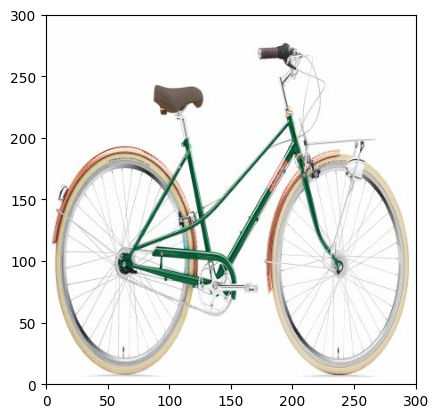

In [10]:
folder_path = "images/bikes"
image_list = load_images_from_folder(folder_path=folder_path)
image_streams = load_image_streams_from_folder(folder_path=folder_path)
im = image_list[0]
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 300, 0, 300])
plt.show()

In [1]:
img = open("images/bikes/bike01.jpg","rb")
dog_bb = [20.0, 15.0, 230, 250.0]
cat_bb = [190.0, 50.0, 325.0, 240.0]

result = computervision_client.analyze_image_in_stream(img, visual_features=[VisualFeatureTypes.objects])
for ob in result.objects:
    if (ob.object_property == "bicycle"):
        predicted_bike_bb = [ob.rectangle.x, ob.rectangle.y, ob.rectangle.x + ob.rectangle.w, ob.rectangle.y + ob.rectangle.h]
        
        # compute the error of detection (differneces between the real location and the predicted location)
        err = 0
        for v in zip(predicted_bike_bb, cat_bb):
            err = err + (v[0] - v[1])**2
        err /= 4
        print("detection error: ", err)

        # show these differences on the image
        im = image_list[0]
        fig = plt.imshow(im)
        fig.axes.add_patch(plt.Rectangle(xy = (dog_bb[0], dog_bb[1]), width = dog_bb[2]-dog_bb[0], height = dog_bb[3]-dog_bb[1], fill = False, color = "red", linewidth = 2))
        fig.axes.add_patch(plt.Rectangle(xy = (cat_bb[0], cat_bb[1]), width = cat_bb[2]-cat_bb[0], height = cat_bb[3]-cat_bb[1], fill = False, color = "blue", linewidth = 2))
        fig.axes.add_patch(plt.Rectangle(xy = (predicted_bike_bb[0], predicted_bike_bb[1]), width = predicted_bike_bb[2]-predicted_bike_bb[0], height = predicted_bike_bb[3]-predicted_bike_bb[1], fill = False, color = "green", linewidth = 2))

        plt.show()

NameError: name 'computervision_client' is not defined

In [5]:





# suppose that 'spam' is the positive class (and 'ham' is the negative class)
# compute the prediction performance

# version 1 - using the sklearn functions
def evalClassificationV1(realLabels, computedLabels, labelNames):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
    
    cm = confusion_matrix(realLabels, computedLabels, labels = labelNames)
    acc = accuracy_score(realLabels, computedLabels)
    precision = precision_score(realLabels, computedLabels, average = None, labels = labelNames)
    recall = recall_score(realLabels, computedLabels, average = None, labels = labelNames)
    return acc, precision, recall 

# version 2 - native code
def evalClassificationV2(realLabels, computedLabels, pos, neg):
    # noCorrect = 0
    # for i in range(0, len(realLabels)):
    #     if (realLabels[i] == computedLabels[i]):
    #         noCorrect += 1
    # acc = noCorrect / len(realLabels)
    acc = sum([1 if realLabels[i] == computedLabels[i] else 0 for i in range(0, len(realLabels))]) / len(realLabels)

    # TP = 0
    # for i in range(0, len(realLabels)):
    #     if (realLabels[i] == 'spam' and computedLabels[i] == 'spam'):
    #         TP += 1
    TP = sum([1 if (realLabels[i] == pos and computedLabels[i] == pos) else 0 for i in range(len(realLabels))])
    FP = sum([1 if (realLabels[i] == neg and computedLabels[i] == pos) else 0  for i in range(len(realLabels))])
    TN = sum([1 if (realLabels[i] == neg and computedLabels[i] == neg) else 0 for i in range(len(realLabels))])
    FN = sum([1 if (realLabels[i] == pos and computedLabels[i] == neg) else 0  for i in range(len(realLabels))])

    precisionPos = TP / (TP + FP)
    recallPos = TP / (TP + FN)
    precisionNeg = TN / (TN + FN)
    recallNeg = TN / (TN + FP)

    return acc, precisionPos, precisionNeg, recallPos, recallNeg

bike01.jpg -> Detected bicycle IoU: 0.93


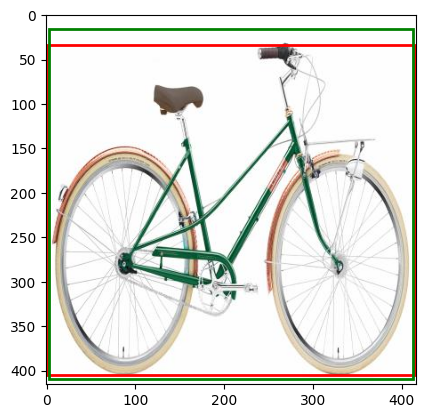

bike02.jpg -> Detected bicycle IoU: 0.93


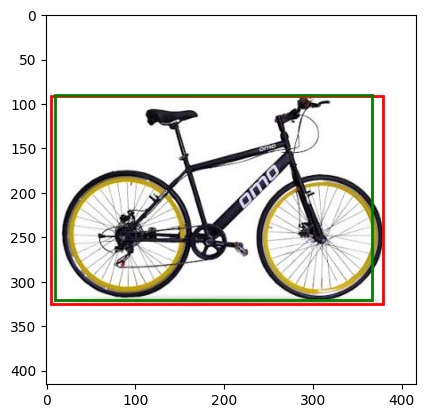

bike03.jpg -> Detected bicycle IoU: 0.70


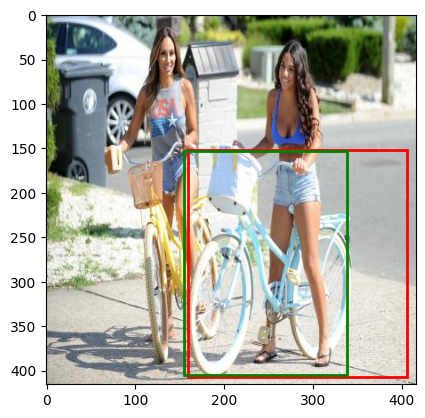

bike04.jpg -> Detected bicycle IoU: 0.98


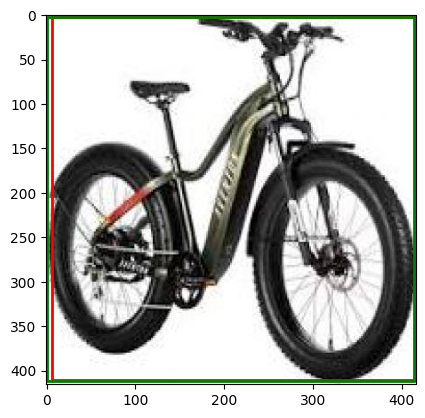

bike05.jpg -> Detected bicycle IoU: 0.66


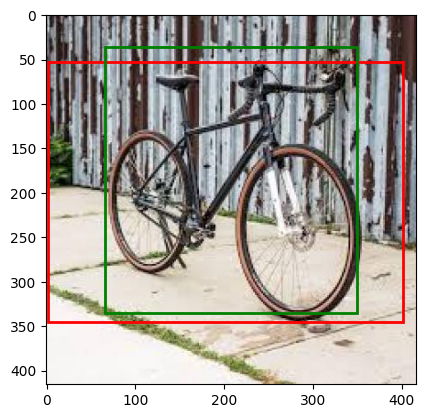

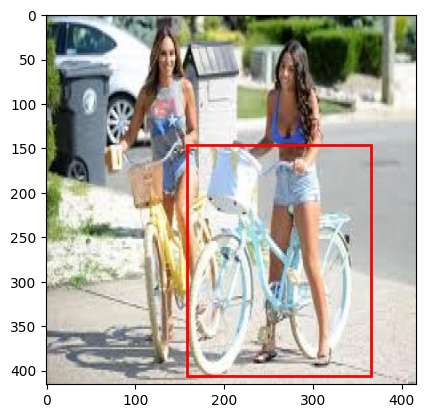

bike07.jpg -> Detected bicycle IoU: 0.65


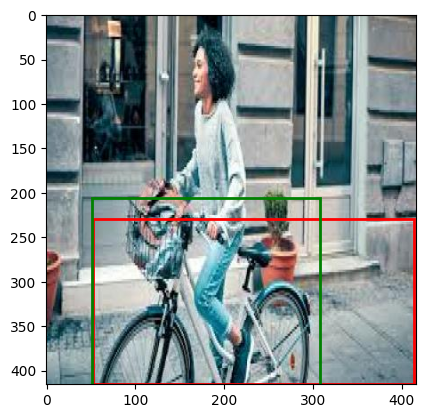

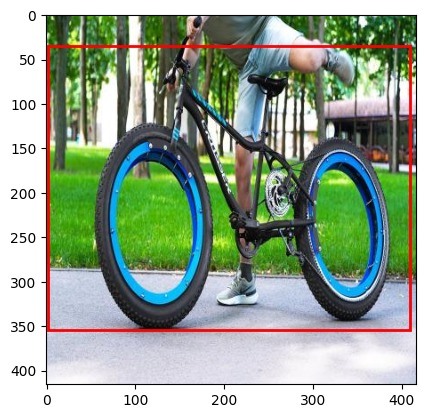

bike09.jpg -> Detected bicycle IoU: 0.95


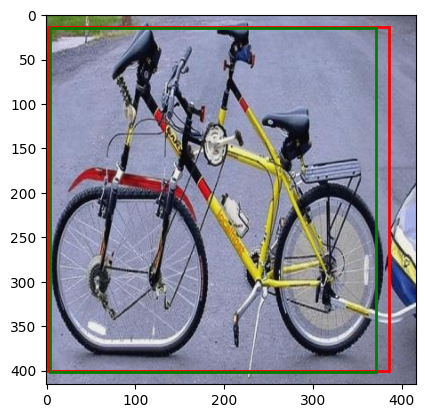

bike10.jpg -> Detected bicycle IoU: 0.85


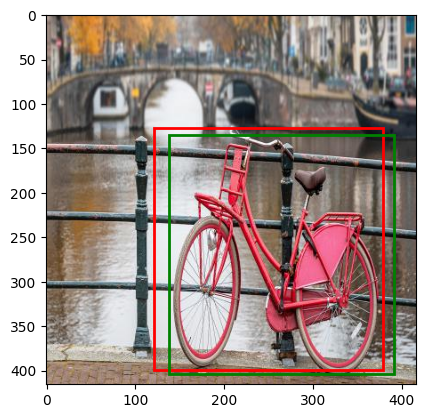

No annotation file found for traffic01.jpg, skipping IoU computation.


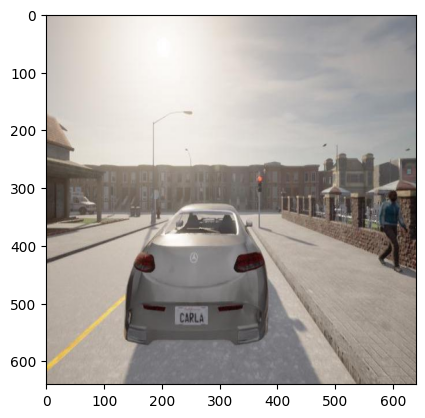

No annotation file found for traffic02.jpg, skipping IoU computation.


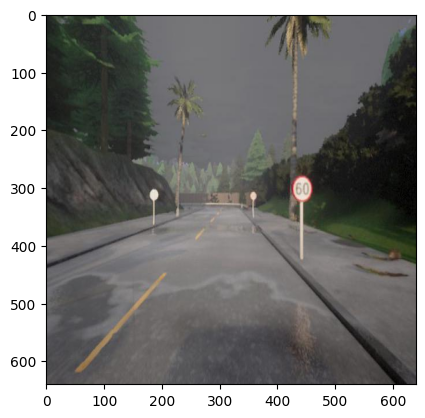

No annotation file found for traffic03.jpg, skipping IoU computation.


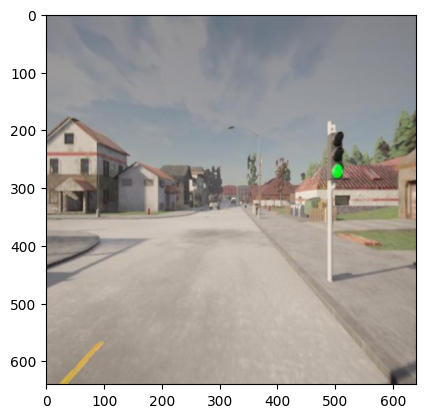

No annotation file found for traffic04.jpg, skipping IoU computation.


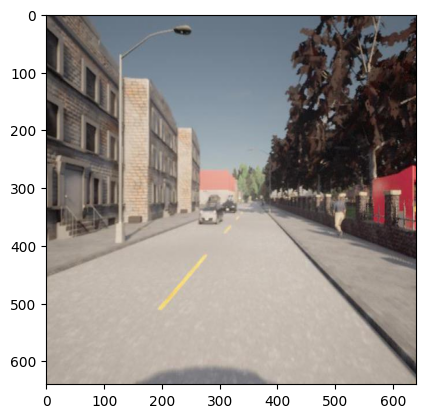

No annotation file found for traffic05.jpg, skipping IoU computation.


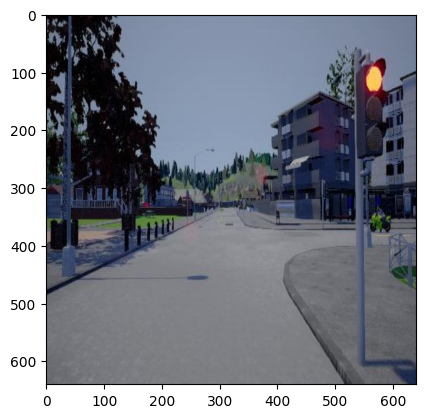

No annotation file found for traffic06.jpg, skipping IoU computation.


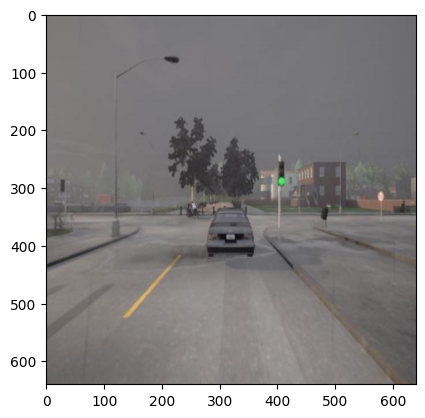

No annotation file found for traffic07.jpg, skipping IoU computation.


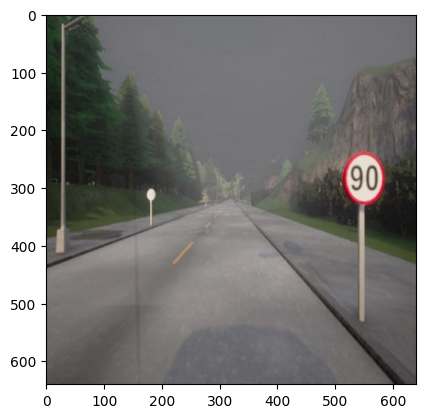

No annotation file found for traffic08.jpg, skipping IoU computation.


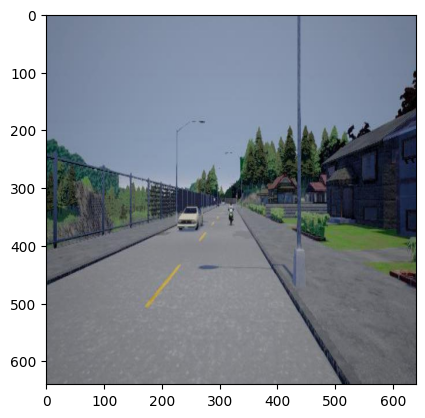

No annotation file found for traffic09.jpg, skipping IoU computation.


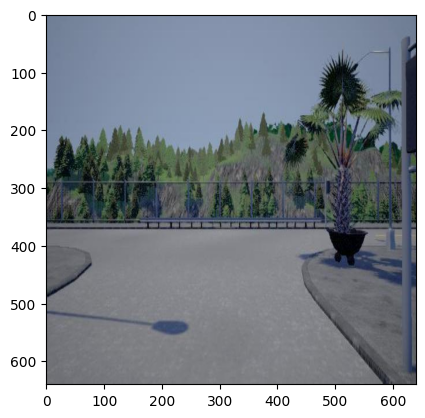

No annotation file found for traffic10.jpg, skipping IoU computation.


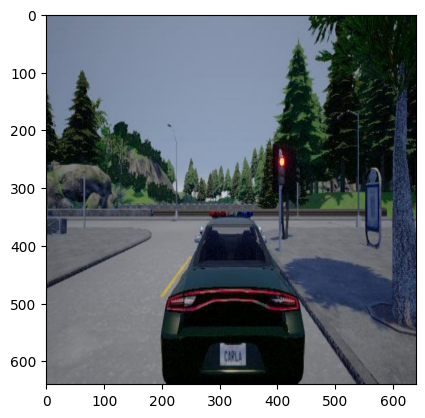


Metrics:
acc: 0.9  precision: [1.         0.83333333]  recall: [0.8 1. ]


In [9]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# ...existing code...
realLabels =        ['bike','bike','bike','bike','bike','bike','bike','bike','bike','bike',
                     'no_bike','no_bike','no_bike','no_bike','no_bike','no_bike','no_bike','no_bike','no_bike','no_bike']
computedLabels =    []

def parse_annotation(annotation_path):
    """Parse an XML annotation file and return bounding box coordinates [x1, y1, x2, y2]."""
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    obj = root.find("object")
    bndbox = obj.find("bndbox")
    x_min = float(bndbox.find("xmin").text)
    y_min = float(bndbox.find("ymin").text)
    x_max = float(bndbox.find("xmax").text)
    y_max = float(bndbox.find("ymax").text)
    return [x_min, y_min, x_max, y_max]

def compute_iou(boxA, boxB):
    """Compute Intersection over Union (IoU) for two boxes given as [x1, y1, x2, y2]."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    union = float(boxAArea + boxBArea - interArea)
    if union == 0:
        return 0.0
    return interArea / union

def analyze_bike_images_with_annotations(folder_path, annotation_path, computervision_client, confidence_threshold=0.7):
    """Analyze bike images, draw both annotation boxes and detection boxes if available, then compute IoU."""
    image_list = load_images_from_folder(folder_path)
    image_streams = load_image_streams_from_folder(folder_path)
    image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg','.jpeg','.png'))])
    
    for idx, img_stream in enumerate(image_streams):
        image_name = os.path.splitext(image_files[idx])[0]
        annot_file = os.path.join(annotation_path, image_name + ".xml")
        
        has_annotation = os.path.exists(annot_file)
        gt_box = None
        if has_annotation:
            gt_box = parse_annotation(annot_file)
        
        # Analyze with Azure
        result = computervision_client.analyze_image_in_stream(
            img_stream, visual_features=[VisualFeatureTypes.tags, VisualFeatureTypes.objects]
        )

        # Find bicycle boxes
        detection_boxes = []
        detected_bike = False
        for ob in result.objects:
            if ob.object_property == "bicycle" and ob.confidence >= confidence_threshold:
                detection_boxes.append([
                    ob.rectangle.x,
                    ob.rectangle.y,
                    ob.rectangle.x + ob.rectangle.w,
                    ob.rectangle.y + ob.rectangle.h
                ])
                detected_bike = True
        
        # Update computed labels
        if detected_bike:
            computedLabels.append("bike")
        else:
            computedLabels.append("no_bike")
        
        # Plot the image
        im = image_list[idx]
        fig = plt.imshow(im)
        
        # If an annotation exists, draw the ground truth box in red
        if gt_box:
            fig.axes.add_patch(
                plt.Rectangle(
                    (gt_box[0], gt_box[1]),
                    gt_box[2] - gt_box[0],
                    gt_box[3] - gt_box[1],
                    fill=False, color="red", linewidth=2
                )
            )
        
        # Draw detected bicycle boxes in green and compute IoU if we have ground truth
        for db in detection_boxes:
            fig.axes.add_patch(
                plt.Rectangle(
                    (db[0], db[1]),
                    db[2] - db[0],
                    db[3] - db[1],
                    fill=False, color="green", linewidth=2
                )
            )
            if gt_box:
                iou = compute_iou(gt_box, db)
                print(f"{image_files[idx]} -> Detected bicycle IoU: {iou:.2f}")
        
        if not has_annotation:
            print(f"No annotation file found for {image_files[idx]}, skipping IoU computation.")
        
        plt.show()

# Example usage:
analyze_bike_images_with_annotations("images/bikes", "annotattions/", computervision_client)

acc, prec, recall = evalClassificationV1(realLabels, computedLabels, ['bike','no_bike'])
print("\nMetrics:")
print('acc:', acc, ' precision:', prec, ' recall:', recall)